# Event Detection Demystified

This notebook derives a basic event detection technique and shows an application on real streamflow data.

## Requirements

The following examples require python 3.8+, pandas, numpy, matplotlib, seaborn, and [evaluation_tools](https://github.com/NOAA-OWP/evaluation_tools). The Makefile in this repository will automatically generate a compatible Python virtual environment. Running `make events` will create the required environment and launch this notebook in your browser.

## Background and Motivation

Event-based analysis is commonly conducted using [baseflow separation](https://doi.org/10.1002/hyp.5675) techniques. Baseflow separation is the process of modeling the underlying low frequency components in a streamflow hydrograph to identify periods of event flow. Quite often "event" refers to a rainfall-driven direct runoff storm-event. Generally speaking, most of the interesting hydrology happens during these events. Hydrologists are interested in analyzing these events to uncover the dynamic processes that govern a catchment's streamflow response to precipitation.

The figure below shows an example of using baseflow separation to divide a streamflow hydrograph into baseflow and direct runoff components. Contiguous periods of direct runoff are "events". The figure below shows three such events. This figure was generated assuming baseflow linearly increased during storm events by 0.04 cubic feet per second per hour. This is called the "straight line method" of baseflow separation. An alternative to assuming a constant increase in discharge is to apply expert knowledge to determine the start and end of a particular event, then simply draw a straight line between them.

![](images/baseflow.png)

It may be easy to identify and analyze a single event. However, manually extracting events becomes tedious as the amount of data and the number of events increases. It's also difficult to manually extract events in an objective and standardized way. We can use a variety of signal processing techniques to automatically identify and analyze hydrological events in long streamflow records. The process of automatically identifying interesting features (events) in a time series is called *Event Detection*.

## Overview

This example consists of 7 high-level steps that includes data retrieval, preprocessing, isolating hydrological events, and a simple event-based analysis. The steps are given below:

1. Retrieve and prepare data
2. Filter noise and model trend
3. Detrend data
4. Apply in-event criteria
5. Discretize events
6. Tweak event timing
7. Filter events

### Alternatives

There are many potential methods of event detection, but in general they will all follow similar steps to those outlined above. Potentially any signal filtering or time series feature technique could be applied during steps 2 and 3. Implementation details may differ significantly, but the goal of identifying desired/undesired signal components and amplifying/attentuating these components remains the same. Some examples of techniques that could be applied to detect events are given below.

Chaovalit, P., Gangopadhyay, A., Karabatis, G., & Chen, Z. (2011). Discrete wavelet transform-based time series analysis and mining. ACM Computing Surveys (CSUR), 43(2), 1-37.

Eckhardt, K. (2005). How to construct recursive digital filters for baseflow separation. Hydrological Processes: An International Journal, 19(2), 507-515.

Hildenbrand, T. G. (1983). FFTFIL; a filtering program based on two-dimensional Fourier analysis of geophysical data (No. 83-237). US Geological Survey,.

Maestre, A., Regina, J. A., Ogden, F. L., Frazier, N. J., Wolford, R., Kim, J., & Flowers, T. (2019, December). Runoff Identification and Delimitation in Discharge Series Using Forward and Backward Moving Averages. In AGU Fall Meeting Abstracts (Vol. 2019, pp. H43I-2143).

Regina, J.A. & Ogden, F.L. (2021). Automated Correction of Systematic Errors in High Frequency Stage Data from V‐Notch Weirs using Time Series Decomposition. Hydrological Processes: An International Journal, under review.

Rolim, L. Z. R., & de Souza Filho, F. D. A. (2020). Shift Detection in Hydrological Regimes and Pluriannual Low-Frequency Streamflow Forecasting Using the Hidden Markov Model. Water, 12(7), 2058.

## 1. Retrieve and Prepare Data

Here we use the Evaluation Tools [NWIS Client](https://noaa-owp.github.io/evaluation_tools/evaluation_tools.nwis_client.html) subpackage to retrieve streamflow measurements from the [USGS Instantaneous Values Web Service](https://waterservices.usgs.gov/rest/IV-Service.html) for [Little Hope Creek](https://waterdata.usgs.gov/nc/nwis/uv?site_no=02146470) in North Carolina. We also clean and resample the data to prepare them for event detection. We choose to resample the observatations to an hourly time series using the first value in each 1-hour bin. However, event detection can run on any regularly sampled time series without missing data.

The Event Detection subpackage in Evaluation Tools operates on time series data. In general terms a time series is a time-stamped series of regularly sampled values. These values can be streamflow measurements or modeled values. In the context of Evaluation Tools, these time series are normally stored as `pandas.Series` with a monotonically increasing `pandas.DatetimeIndex`. For more information on using `pandas` see the [Pandas API Reference](https://pandas.pydata.org/pandas-docs/stable/reference/index.html).

In [1]:
# Import modules
from evaluation_tools.nwis_client.iv import IVDataService
from evaluation_tools.events.event_detection import decomposition as ev
import numpy as np
import pandas as pd
import pubtools.plot as plt
%matplotlib inline

# Pick a site
# Little Hope Creek is the ideal site for event detection
#  This basin is relatively small (2.63 sq. mi.) and exhibits easily resolved "flashy" events.
sites = '02146470' # LITTLE HOPE CR AT SENECA PLACE AT CHARLOTTE, NC

# The Mississippi River is not ideal for event detection
#  This basin is large (932,800.0 sq. mi.) and flows change gradually.
#  The meaning of "event" may not be well-defined here
# sites = '07032000' # MISSISSIPPI RIVER AT MEMPHIS, TN

# The Red River of the North is not ideal for event detection
#  This basin is quite large, subject to freezing and snowmelt driven flow.
#  We might be able to define events here, but these will require different parameters than 
#  the flashy rainfall-driven events at Little Hope Creek.
# sites = '05054000' # RED RIVER OF THE NORTH AT FARGO, ND

# This gage on the Purgatoire river is not ideal for event detection
#  This gage is downstream of a controlled reservoir.
#  What's considered an hydrological event downstream of a flow control structure?
# sites = '07124410' # PURGATOIRE RIVER BELOW TRINIDAD LAKE, CO.

# Retrieve streamflow data
observations = IVDataService.get(
    sites=sites,
    startDT='2019-10-01',
    endDT='2020-09-30'
    )

# Isolate time series of streamflow measurements
observations = observations[['value_date', 'value']]
observations = observations.drop_duplicates(subset=['value_date'])
observations = observations.set_index('value_date')
observations = observations.resample('H').first().ffill()

# Look at data
observations.head()

,value
value_date,
2019-10-01 00:00:00,32.299999
2019-10-01 01:00:00,32.299999
2019-10-01 02:00:00,32.299999
2019-10-01 03:00:00,32.299999
2019-10-01 04:00:00,32.299999


## 2. Filter Noise and Model Trend

The first issue to address with real data is noise. Small high-frequency fluctations in real data may be erroneously identified as "events" by any event detection algorithm. To reduce the number of false positive events it's important to filter the data before applying event detection. Here we applied an [exponentially weight moving average](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) to the data to smooth out these noisy fluctuations.

Next we can employ a variety of filters to model the low-frequency trend component of a streamflow time series. Here we use a rolling minimum filter to model the trend. Instead of using a rolling minimum, we could apply a baseflow filter to approximate the trend. However, baseflow filters typically require extra information about catchment characteristics. The combination of filters used here assumes event durations will generally fall between 6-hours and 7-days. Furthermore, a good rule-of-thumb for this filter is to make sure your available data is at least 4-5 times longer than your window size (28-35 days for a 7-day window). In this case, we retrieved one year of data.

In [2]:
# Smooth noisy data
observations['smooth'] = observations['value'].ewm(halflife='6H', times=observations.index).mean()

# Model the trend using a 7-day rolling minimum
observations['trend'] = ev.rolling_minimum(observations['smooth'], '7D')

# Look at data
observations.head()

,value,smooth,trend
value_date,,,
2019-10-01 00:00:00,32.299999,32.299999,32.299999
2019-10-01 01:00:00,32.299999,32.299999,32.299999
2019-10-01 02:00:00,32.299999,32.299999,32.299999
2019-10-01 03:00:00,32.299999,32.299999,32.299999
2019-10-01 04:00:00,32.299999,32.299999,32.299999


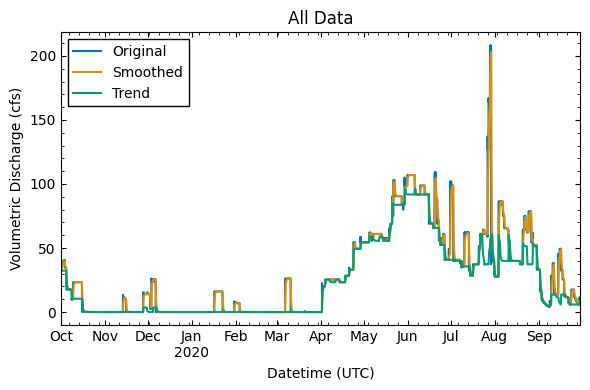

In [3]:
# Set log-scale for plots
if observations['value'].max() >= 1000.0:
    logy=True
else:
    logy=False

# Plot all data
plt.plot_dataframe(
    observations,
    logy=logy,
    legend=['Original', 'Smoothed', 'Trend'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="All Data"
    )

07124410


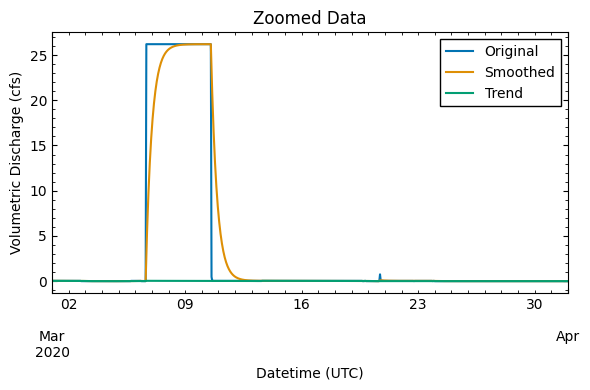

In [4]:
# Detailed plot
begin = pd.Timestamp("2020-03-01")
end = pd.Timestamp("2020-04-01")

# Set different time period for '07032000'
if sites in ['07032000', '05054000']:
    begin = pd.Timestamp("2020-04-01")
    end = pd.Timestamp("2020-05-01")
print(sites)
    
# Plot
plt.plot_dataframe(
    observations.loc[begin:end, :],
    logy=logy,
    legend=['Original', 'Smoothed', 'Trend'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="Zoomed Data"
    )

## 3. Detrend Data

To detrend the data we assume a three component additive model of streamflow at time $t$ given by:

$$ Q_t = T_t + R_t + N_t $$

Where:
 - $Q_t = $ total streamflow,
 - $T_t = $ streamflow trend,
 - $R_t = $ event flow, and
 - $N_t = $ noise.
 
Up to this point we've approximated the trend component ($T_t$) using a rolling minimum filter. We've also reduced the noise, but have not completely eliminated it as will be seen. An additional implicit assumption is that the event flow component ($R_t) is zero during non-event periods.


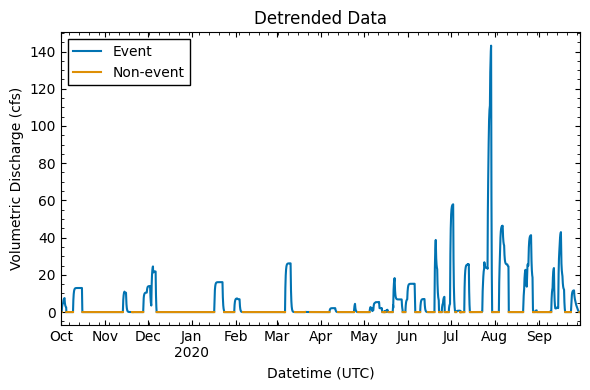

In [5]:
# Detrend the data
observations['detrended'] = observations['smooth'].sub(observations['trend'])

# Ignore detrended values below measurement precision
observations.loc[(observations['detrended'] < 0.01), 'detrended'] = 0.0

# Detrended signal should have a zero median if events are sufficiently rare
#  In this case, we're assuming events make up less than 50% of the entire signal
#  We will further assume that any residual noise in the detrended data is symmetric,
#  so to eliminiate this error we'll remove twice the residual median
residual = observations['detrended'].median() * 2.0
observations.loc[(observations['detrended'] < residual), 'detrended'] = 0.0

# Plot all detrended data
observations['zeros'] = observations.loc[observations['detrended'] == 0.0, 'detrended']
plt.plot_dataframe(
    observations[['detrended', 'zeros']],
    logy=False,
    legend=['Event', 'Non-event'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="Detrended Data"
    )

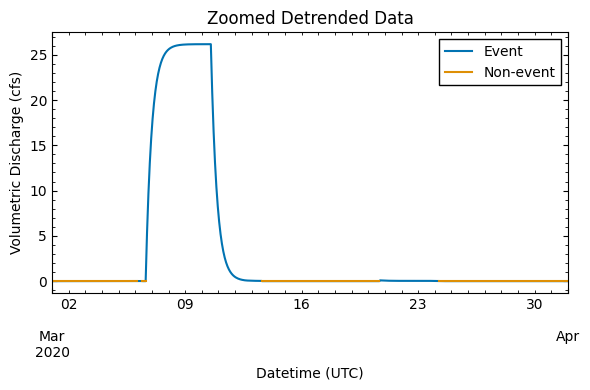

In [6]:
# Detailed plot of detrended data
plt.plot_dataframe(
    observations.loc[begin:end, ['detrended', 'zeros']],
    logy=False,
    legend=['Event', 'Non-event'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="Zoomed Detrended Data"
    )

## 4. Apply In-event Criteria

With the trend removed, we'll assume the remaining non-zero values indicate in-event values. For every time stamp we'll indicate whether the corresponding value is *in an event* with `True` or *not in an event* with `False`. Detrended values greater than 0.0 are *in an event*.

To summarize: up to this point we used the smoothed data to determine the timing of correspoding *in-event* values in the original streamflow time series. The plot below displays the original time series with the applied event criteria.

In [7]:
# Mask in-event measurements
observations['in_event'] = (observations['detrended'] > 0.0)

# Look at data
observations.head()

,value,smooth,trend,detrended,zeros,in_event
value_date,,,,,,
2019-10-01 00:00:00,32.299999,32.299999,32.299999,0.0,0.0,False
2019-10-01 01:00:00,32.299999,32.299999,32.299999,0.0,0.0,False
2019-10-01 02:00:00,32.299999,32.299999,32.299999,0.0,0.0,False
2019-10-01 03:00:00,32.299999,32.299999,32.299999,0.0,0.0,False
2019-10-01 04:00:00,32.299999,32.299999,32.299999,0.0,0.0,False


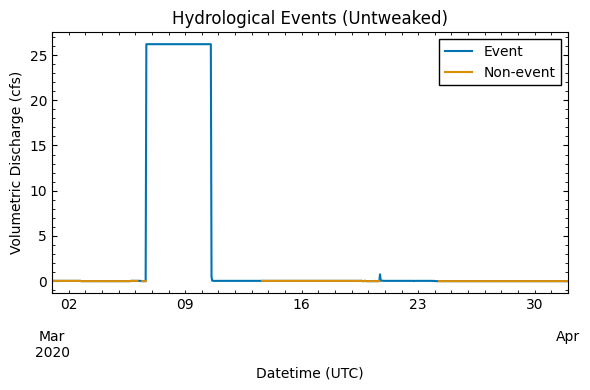

In [8]:
# Detailed plot of detrended real data
subset = observations.loc[begin:end, :].copy(deep=True)
subset.loc[~subset['in_event'], 'zeros'] = subset.loc[~subset['in_event'], 'value']
plt.plot_dataframe(
    subset[['value', 'zeros']],
    logy=logy,
    legend=['Event', 'Non-event'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="Hydrological Events (Untweaked)"
    )

## 5. Discretize Events

Now that in-event values are marked, we can resolve contiguous in-event measurements into individual whole events.


In [9]:
# Aggregate continguous event measurements into discrete events
events = ev.event_boundaries(observations['in_event'])

# Look at events
events.head()

,start,end
0,2019-10-01 16:00:00,2019-10-04 20:00:00
1,2019-10-09 15:00:00,2019-10-16 04:00:00
2,2019-11-13 16:00:00,2019-11-20 05:00:00
3,2019-11-20 14:00:00,2019-11-20 14:00:00
4,2019-11-27 23:00:00,2019-12-07 09:00:00


## 6. Tweak Event Timing

The various smoothing filters employed may impart a phase-shift on event values. This introduces additional uncertainty into event start and end times (around March 17th and 23rd). As seen above, some of our events exhibit delayed start times. The algorithm correctly identified an event, but the expected start time occurs after flows have already begun to rise. We want the event start times to coincide with when streamflow begins to rise. To achieve this we'll correct event start times to a local minimum value within 7-hours.


In [10]:
# Tweak events
events['start'] = events['start'].apply(ev.find_local_minimum, radius='7H', timeseries=observations['value'])

# Adjust event points and inspect
subset['zeros'] = subset['value']
for e in events.itertuples():
    subset.loc[e.start:e.end, 'zeros'] = np.nan

# Look at tweaked events
events.head()

,start,end
0,2019-10-01 09:00:00,2019-10-04 20:00:00
1,2019-10-09 08:00:00,2019-10-16 04:00:00
2,2019-11-13 09:00:00,2019-11-20 05:00:00
3,2019-11-20 07:00:00,2019-11-20 14:00:00
4,2019-11-27 16:00:00,2019-12-07 09:00:00


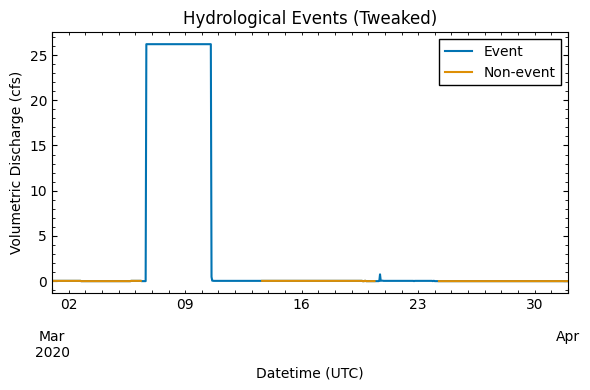

In [11]:
# Plot new events
plt.plot_dataframe(
    subset[['value', 'zeros']],
    logy=logy,
    legend=['Event', 'Non-event'], 
    xlabel="Datetime (UTC)",
    ylabel="Volumetric Discharge (cfs)",
    title="Hydrological Events (Tweaked)"
    )

## 7. Filter Events

Depending upon our analysis, data sources, and expected uncertainties we may wish to filter out events with certain characteristics. In this case we've chosen to omit the smaller events. The code below filters out events with durations less than 6 hours or peak flows less than 10 cubic feet per second.


In [12]:
# Compute event durations in hours
events['duration'] = (events['end'].sub(events['start'])).div(pd.Timedelta('1H'))

# Compute peak flows in cfs
events['peak'] = events.apply(
    lambda e: observations['value'].loc[e.start:e.end].max(),
    axis=1
    )

# Filter out small events less than 6 hours or with peaks less than 10 CFS
events = events[events['duration'] >= 6.0]
events = events[events['peak'] >= 10.0]

# Look at events
events.head()

,start,end,duration,peak
0,2019-10-01 09:00:00,2019-10-04 20:00:00,83.0,40.799999
1,2019-10-09 08:00:00,2019-10-16 04:00:00,164.0,23.299999
2,2019-11-13 09:00:00,2019-11-20 05:00:00,164.0,13.400000
4,2019-11-27 16:00:00,2019-12-07 09:00:00,233.0,26.200001
5,2020-01-16 14:00:00,2020-01-23 19:00:00,173.0,16.100000


## Example Event-Based Analyses

Now that we have a population of runoff events, we can explore the events for interesting quantitities. The plots below show histograms of peak event discharges and event durations in hours.


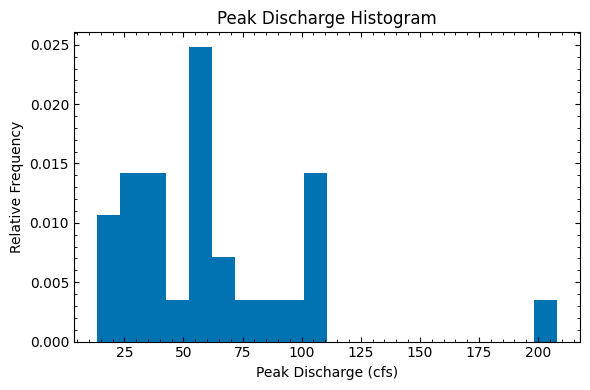

In [13]:
# Plot histogram of peaks and durations
plt.hist(
    events['peak'],
    xlabel="Peak Discharge (cfs)",
    ylabel="Relative Frequency",
    title="Peak Discharge Histogram"
    )

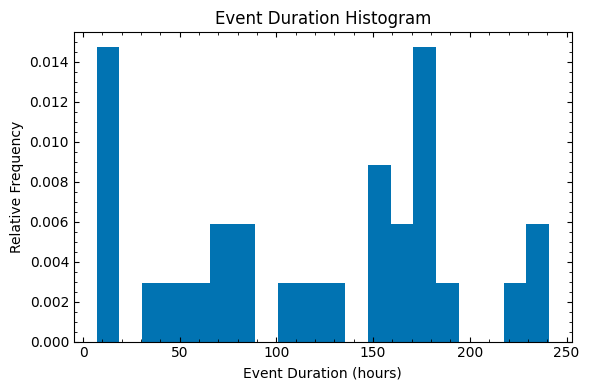

In [14]:
# Plot histogram of durations
plt.hist(
    events['duration'],
    xlabel="Event Duration (hours)",
    ylabel="Relative Frequency",
    title="Event Duration Histogram"
    )